# <center> <b> <font color='blue'> ELECTRICAL PRODUCTION </center> </b> </font>

## Table of Contents

1. [Problem Statement](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data Loading and pre-processing](#4)
5. [Model selection](#5)
6. [Making predictions](#6)
7. [Annex](#annex)

<a name="1"></a>
## <font color='#2e86c1'> <b> 1. Problem Statement </font> </b>

We're gonna predict the electrical production. It is a time series problem.

<a name="2"></a>
## <font color='#2e86c1'> <b> 2. Setup </font> </b>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
import pandas as pd
from tensorflow.keras import layers

2024-10-11 17:37:51.701582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 17:37:51.701916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 17:37:51.834098: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
logging.set_verbosity(logging.ERROR)

<a name="3"></a>
## <font color='#2e86c1'> <b> 3. Helper Functions </font> </b>

In [4]:
# plot time series
import matplotlib.pyplot as plt

def plot_series(time, series, title, xlabel, ylabel, format="-", start=0, end=None, color='blue'):
    plt.plot(time[start:end], series[start:end], format, color=color)

    # Show only some x values to avoid clutter
    ticks_interval = 50
    plt.xticks(data.index[::ticks_interval], data.index[::ticks_interval])
    
    # Set title with bold and colored text
    plt.title(title, fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'darkred'})
    
    # Set xlabel with bold and colored text
    plt.xlabel(xlabel, fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'darkorange'})
    
    # Set ylabel with bold and colored text
    plt.ylabel(ylabel, fontdict={'fontsize': 12, 'fontweight': 'bold', 'color': 'darkorange'})
    
    plt.grid(True)
    plt.show()  # Show the plot if desired

    

def plot_train_val(time_train, series_train, time_valid, series_valid):
    plt.figure(figsize=(12, 6))
    plt.plot(time_train, series_train, label='Training Set', color='blue')
    plt.plot(time_valid, series_valid, label='Validation Set', color='orange')

    # Show only some x values to avoid clutter
    ticks_interval = 50
    plt.xticks(data.index[::ticks_interval], data.index[::ticks_interval])

    # Adding titles and labels
    plt.title('Training and Validation Sets')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.axvline(x=time_train[-1], color='red', linestyle='--', label='Split Point')  # Optional: Split line
    plt.legend()
    plt.grid()
    plt.show()
    


<a name="4"></a>
## <font color='#2e86c1'> <b> 4. Loading and pre-processing data </font> </b>

This project uses the [Electric Production](https://www.kaggle.com/datasets/shenba/electricity-production) dataset by Kaggle.

### Loading data

In [5]:
!cd data && ls

Electric_Production.csv


In [6]:
data = pd.read_csv('data/Electric_Production.csv')
data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


### Exploration

In [7]:
data.shape

(397, 2)

In [8]:
data.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [10]:
data.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

There are no missing values.

In [11]:
times = data['DATE']
consumption = data['IPG2211A2N']

In [12]:
# Class for storing data
@dataclass
class G:
    #TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    #times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = times.values
    SERIES = consumption.values
    SPLIT_TIME = 250
    WINDOW_SIZE = 7
    HORIZON = 1
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 200
    SPLIT_SIZE=0.8

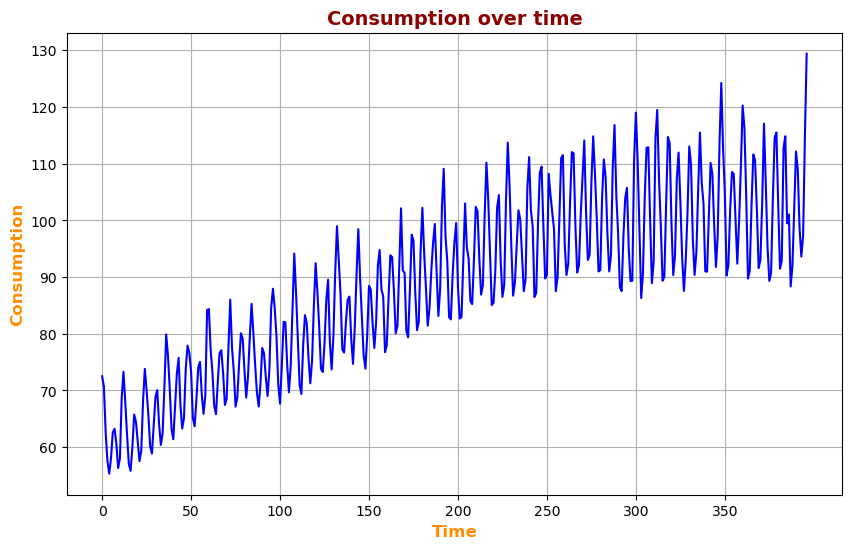

In [13]:
# plot time series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, 'Consumption over time', 'Time', 'Consumption')
plt.show()

We can see a growing trend.

### Train/Test split

In [105]:
len(G.TIME)

397

In [107]:
int(len(G.TIME)*G.SPLIT_SIZE)

317

In [14]:
# train/test split
def train_val_split(time, series, split_size):
    """
    Split the time series data into training and validation sets.
    We do not shuffle the data because is a time series problem.

    Parameters:
    - time (list-like): List or array containing the time index of the time series.
    - series (list-like): List or array containing the values of the time series.
    - split_size (float): The proportion of data to be allocated for training.
                          Value should be between 0 and 1.

    Returns:
    - time_train (list-like): Time index of the training set.
    - series_train (list-like): Values of the training set.
    - time_valid (list-like): Time index of the validation set.
    - series_valid (list-like): Values of the validation set.

    Example:
        If time = [1, 2, 3, 4, 5] and series = [10, 20, 30, 40, 50],
            and split_size = 0.8, then the function returns:
                time_train = [1, 2, 3]
                series_train = [10, 20, 30]
                time_valid = [4, 5]
                series_valid = [40, 50]
    """
    
    # índice de la divisón
    training_size = int(len(time)*split_size)

    time_train = time[:training_size]
    series_train = series[:training_size]
    time_valid = time[training_size:]
    series_valid = series[training_size:]

    return time_train, series_train, time_valid, series_valid

In [15]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_SIZE)

In [16]:
time_train.shape, series_train.shape, time_valid.shape, series_valid.shape

((317,), (317,), (80,), (80,))

Let's plot our sets.

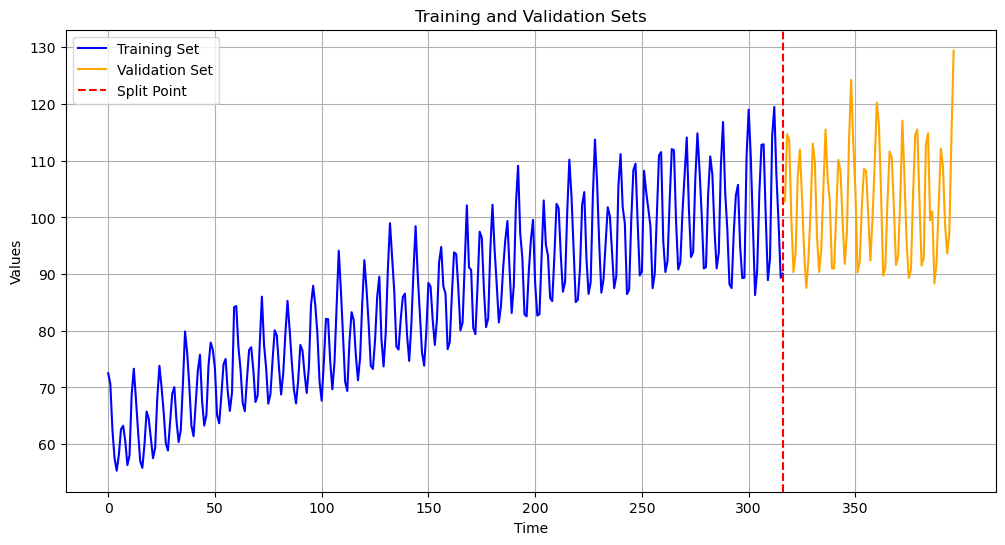

In [17]:
plot_train_val(time_train, series_train, time_valid, series_valid)

### Windowing the dataset

In [18]:
def windowed_dataset(series, 
                     window_size=G.WINDOW_SIZE, 
                     horizon=G.HORIZON, 
                     batch_size=32, 
                     shuffle_buffer=10,
                     shuffle=True):
    
    """
    Create a windowed dataset for time series prediction.

    Parameters:
    - series: 1D array-like structure containing the time series data.
    - window_size: Size of the window for features.
    - horizon: 
    - batch_size: Number of samples per batch.
    - shuffle_buffer: Size of the shuffle buffer.
    - shuffle: Boolean indicating whether to shuffle the dataset.

    Returns:
    - A TensorFlow dataset of input-output pairs.
    """
    
    if window_size <= 0 or batch_size <= 0:
        raise ValueError("window_size and batch_size must be greater than 0")
    
    # Create the dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + horizon)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Split the windows into features and labels
    # w[:-horizon]: all but the last 'horizon' elements for features
    # w[-horizon:]: the last 'horizon' elements for labels
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))  # Use -horizon for labels
    
    # Batch the dataset
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, 
                             batch_size=G.BATCH_SIZE)

In [21]:
# Apply to the validation set; NO shuffle
val_set = windowed_dataset(series_valid, window_size=G.WINDOW_SIZE, 
                           batch_size=G.BATCH_SIZE,shuffle=False)

<a name="5"></a>
## <font color='#1a5276'> <b> 5. Model Selection </font> </b>

In [22]:
tf.random.set_seed(42)

results = {}

In [23]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
 
    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [24]:
def store_results(results, name, data):
    
    # Store the data in the results dictionary
    results[name] = data
    
    return results

<a name="5.0"></a>
### <font color='#2874a6'> <b> 5.0. Baseline </font> </b>

In [25]:
# naive forecast
naive_forecast = series_valid[:-1]

In [26]:
naive_results = evaluate_preds(y_true=series_valid[1:],
                               y_pred=naive_forecast)

In [27]:
naive_results

{'mae': 8.270276, 'mse': 89.44624, 'rmse': 9.4576025, 'mape': 8.038783}

In [28]:
store_results(results, 'Naive Forecast', naive_results)

{'Naive Forecast': {'mae': 8.270276,
  'mse': 89.44624,
  'rmse': 9.4576025,
  'mape': 8.038783}}

In [29]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(series_valid).numpy()

102.71854125

<a name="5.1"></a>
### <font color='#2874a6'> <b> 5.1. Simple Dense Model </font> </b>

In [198]:
def build_compile_model_one(name, horizon=G.HORIZON, window_size=G.WINDOW_SIZE, num_features=1):
    # Construct model
    model = tf.keras.models.Sequential([
      #layers.InputLayer(input_shape=(window_size, num_features)),  # Explicit input layer
      #layers.Dense(128, activation="relu"),
      #layers.Dense(10,input_shape=[window_size],activation='relu'),
      layers.InputLayer(input_shape=[window_size]),
      layers.Dense(128,activation='relu'),
      layers.Dense(horizon, activation="linear") # 1? horizon                   
    ], name=name)

    # Compile model
    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae"])
    
    return model


model_1 = build_compile_model_one('Simple_Dense')
model_1.summary()

Model: "Simple_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 128)               1024      
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [199]:
# Fit the model
history_one = model_1.fit(
            train_set,
            epochs=100,
            verbose=0,
            batch_size=64,
            validation_data=val_set)

In [200]:
split_time = training_size = int(len(G.SERIES)*G.SPLIT_SIZE)

split_time = len(G.SERIES) - split_time

split_time


80

In [201]:
series[len_total-len_val-win:len_total-len_val]

array([ 92.775 , 114.3266, 119.488 , 107.3753,  99.1028,  89.3583,
        90.0698])

In [202]:
current_window = series[len_total-len_val-win:len_total-len_val].copy()
current_window[np.newaxis]

array([[ 92.775 , 114.3266, 119.488 , 107.3753,  99.1028,  89.3583,
         90.0698]])

In [203]:
current_window.shape, current_window[np.newaxis].shape

((7,), (1, 7))

In [204]:
def rolling_forecast(model, initial_window, num_predictions):
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window

    for _ in range(num_predictions):
        # Make a prediction based on the current window
        #pred = model.predict(current_window[np.newaxis, :, np.newaxis], verbose=0)[0, 0]
        pred = model.predict(current_window[np.newaxis], verbose=0)
        predictions.append(pred[0][0])

        # Update the window: remove the oldest value and add the new prediction
        current_window = np.roll(current_window, -1)  # Shift the window left
        current_window[-1] = pred[0][0]  # Add the new prediction at the end

    return np.array(predictions)

In [205]:
aux = rolling_forecast(model_1, series[len_total-len_val-win:len_total-len_val] ,80)

In [206]:
aux.shape, series_valid.shape

((80,), (80,))

In [207]:
aux

array([106.77668 , 115.17074 , 111.95563 , 101.500786,  92.90274 ,
        94.92882 , 105.71161 , 114.05438 , 113.24353 , 104.78877 ,
        97.28653 ,  98.054535, 106.15998 , 113.8063  , 114.253555,
       107.84777 , 101.31153 , 101.06624 , 107.24139 , 113.96701 ,
       115.25318 , 110.56748 , 104.98268 , 104.08107 , 108.713936,
       114.517006, 116.32112 , 113.023476, 108.35134 , 107.07151 ,
       110.47736 , 115.40967 , 117.492805, 115.29408 , 111.4679  ,
       110.013855, 112.45961 , 116.59771 , 118.7875  , 117.44344 ,
       114.379456, 112.89577 , 114.60466 , 118.03724 , 120.21404 ,
       119.52182 , 117.128716, 115.71354 , 116.86944 , 119.689095,
       121.7739  , 121.56793 , 119.75361 , 118.46955 , 119.22131 ,
       121.518845, 123.4637  , 123.61097 , 122.287186, 121.170105,
       121.63632 , 123.497185, 125.27685 , 125.67244 , 124.757545,
       123.823906, 124.09744 , 125.5994  , 127.20516 , 127.76763 ,
       127.18835 , 126.440865, 126.592995, 127.80509 , 129.239

In [208]:
type(series_valid)

numpy.ndarray

In [209]:
evaluate_preds(aux, series_valid)

{'mae': 13.835612, 'mse': 294.98062, 'rmse': 17.175, 'mape': 11.6087055}

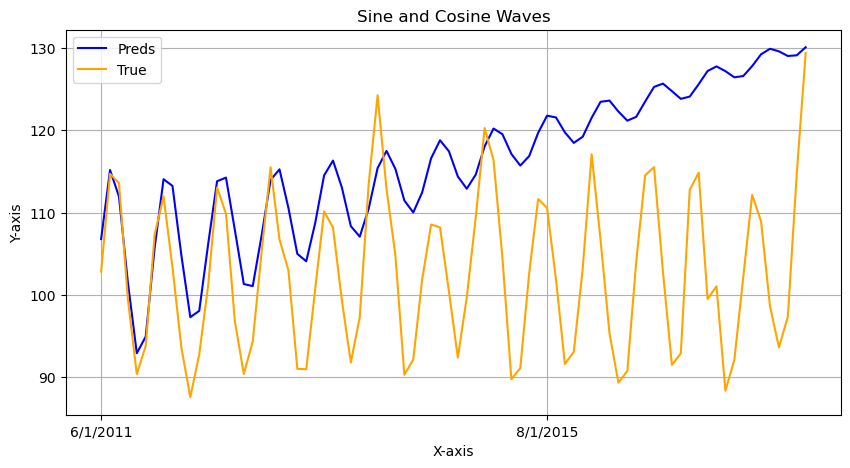

In [210]:
# Plotting
plt.figure(figsize=(10, 5))  # Optional: Set the figure size
plt.plot(time_valid, aux, label='Preds', color='blue')  # Plot the first array
plt.plot(time_valid, series_valid, label='True', color='orange')  # Plot the second array

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Sine and Cosine Waves')
plt.legend()  # Show legend
plt.grid(True)  # Optional: Add a grid


# Set x-ticks to show only specific labels
plt.xticks(np.arange(0, 100, 50))  # Show ticks from 0 to 10 with a step of 1

# Show the plot
plt.show()

In [179]:
time = 3
window_size = G.WINDOW_SIZE
series = G.SERIES

aux = model_1.predict(series[time:time + window_size][np.newaxis], verbose=0)

In [180]:
aux.shape # batch_size, window_size, num_fetaures

(1, 1)

In [181]:
aux

array([[30.206636]], dtype=float32)

In [183]:
aux[0][0]

30.206636

In [247]:
def build_compile_model_two():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100.0) #rescaling
    ]) 
    
    
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"]) 

    return model

In [248]:
model_2 = build_compile_model_two()
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_9 (Lambda)           (None, None, 1)           0         
                                                                 
 bidirectional_9 (Bidirecti  (None, None, 256)         133120    
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
 lambda_10 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 297601 (1.14 MB)
Trainable params: 29760

In [242]:
# Fit the model
history_one = model_2.fit(
            train_set,
            epochs=100,
            verbose=0,
            batch_size=64,
            validation_data=val_set)

In [243]:
aux = rolling_forecast(model_2, series[len_total-len_val-win:len_total-len_val] ,80)

In [244]:
aux

array([75.53072 , 75.530716, 75.530716, 75.530716, 75.53071 , 75.530716,
       75.53071 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 , 75.53069 ,
       75.53069 , 75.53069 ], dtype=float32)

In [245]:
evaluate_preds(aux, series_valid)

{'mae': 27.187847, 'mse': 830.66345, 'rmse': 28.821232, 'mape': 35.99576}

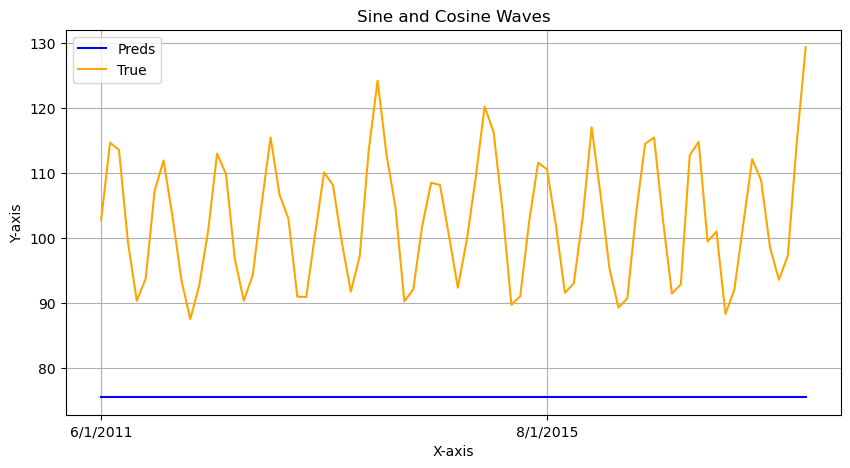

In [246]:
# Plotting
plt.figure(figsize=(10, 5))  # Optional: Set the figure size
plt.plot(time_valid, aux, label='Preds', color='blue')  # Plot the first array
plt.plot(time_valid, series_valid, label='True', color='orange')  # Plot the second array

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Sine and Cosine Waves')
plt.legend()  # Show legend
plt.grid(True)  # Optional: Add a grid


# Set x-ticks to show only specific labels
plt.xticks(np.arange(0, 100, 50))  # Show ticks from 0 to 10 with a step of 1

# Show the plot
plt.show()